# Linear Discretization Model
<p>In this notebook, I'll work to clean up flow model class that I made in my first temporary discretization notebook.</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [53]:
class FlowModel:
    def __init__(self, length = 11, discSize = 10, realLifeLength = 10):
        self.length = length
        self.discSize = discSize
        #self.lengths = np.linspace(0,realLifeLength,(length-1)*discSize + 1)
        self.plotLengths = np.linspace(0,realLifeLength,self.length)
        self.heads = np.zeros(length)
        self.heads[0] = 1
        self.temp = np.linspace(1,0,discSize)
        self.realLifeLength = realLifeLength
        
    def flow1D(self):
        for i in range(self.length-1):
            tempHeads = np.linspace(self.heads[i],self.heads[i+1],self.discSize)
            queue = np.zeros(self.discSize)
            queue[:-1] += (tempHeads[1: ] - tempHeads[:-1])*.01
            queue[1: ] += (tempHeads[:-1] - tempHeads[1: ])*.01
            self.heads[i] += queue[0]
            self.heads[i + 1] += queue[-1]
        self.heads[0] = 1
        self.heads[-1] = 0

## Test the Model

In [6]:
mod = FlowModel(length = 11, discSize = 5)


iters = 1000
for i in range(iters):
    mod.flow1D()


NameError: name 'FlowModel' is not defined

## Measure Time

In [59]:
%%time
mod.flow1D()

Wall time: 5.02 ms


## Plot Results

(0.0, 10.0)

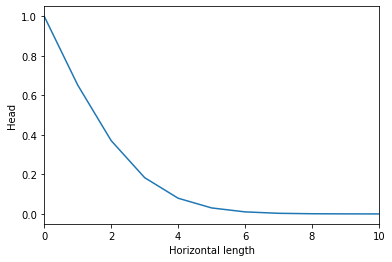

In [62]:
plt.plot(mod.plotLengths, mod.heads)
plt.xlabel("Horizontal length")
plt.ylabel("Head")
plt.xlim(0,mod.realLifeLength)

## Model Analysis
<p>The model works great, I think. It does everything I need it to, at the base level for the moment at least.</p>
<p>Now, the work to be done is to generalize this function to a 2D model. Following this, I think I should try to add a CUDA function to it.</p>

In [17]:
class FlowModel2D:
    def __init__(self, length = 11, depth = 11, discSize = 10, realLifeLength = 10, realLifeDepth = 10):
        self.length = length
        self.depth = depth
        self.discSize = discSize
        self.plotLengths = np.linspace(0,realLifeLength,self.length)
        self.heads = np.zeros((depth,length))
        self.heads[0,0] = 1
        self.realLifeLength = realLifeLength
        self.realLifeDepth = realLifeDepth
        #print(self.discSize)
        
    def flow2D(self):
        for i in range(self.depth-1):
            for j in range(self.length - 1):
                # Create a square queue
                x = np.linspace(self.heads[i,j],self.heads[i,j+1],self.discSize)                    
                y = np.linspace(self.heads[i,j],self.heads[i+1,j],self.discSize)
                X,Y = np.meshgrid(x,y)
                tempHeads = .5*(X + Y)
                queue = np.zeros((self.discSize,self.discSize))
                queue[:-1,:] += (tempHeads[1: ,:] - tempHeads[:-1,:])*.01
                queue[1: ,:] += (tempHeads[:-1,:] - tempHeads[1: ,:])*.01                    
                queue[:,:-1] += (tempHeads[:,1: ] - tempHeads[:,:-1])*.01
                queue[:,1: ] += (tempHeads[:,:-1] - tempHeads[:,1: ])*.01
                self.heads[i, j] += queue[0,0]
                self.heads[i + 1, j] += queue[-1,0]
                self.heads[i, j + 1] += queue[0,-1]
                self.heads[i + 1, j + 1] += queue[-1,-1]
                del queue
                del tempHeads
        self.heads[0,0] = 1
        self.heads[-1,-1] = 0
        
        for i in range(self.depth):
            for j in range(self.length):
                if self.heads[i,j] <= 0:
                    self.heads[i,j] = 0

        

In [21]:
mod2 = FlowModel2D(discSize = 3)

for i in range(10000):
    mod2.flow2D()

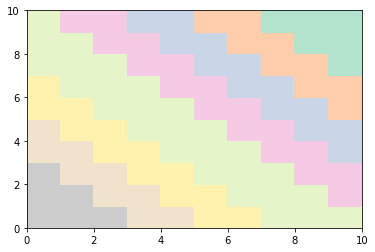

In [26]:
a = np.linspace(1,0,10)
X,Y = np.meshgrid(a,a)

avgLL = (X + Y)*.5

plt.pcolormesh(avgLL, cmap = 'Pastel2')
plt.show()

## Some Problems (and solutions)
<p>I've been having some real problems with trying to figure out how I should implement this model in the 2D sense, and I'm realizing now that I really need to update my Taylor series function. I can't keep using a 1D Taylor series function because I'm no longer using a 1D model.</p>